In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from matplotlib import pyplot as plt
from lemmatizator import lemmatize

In [2]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [3]:
def preproc_doc(doc_series):
    p_corpus = []
    for doc in doc_series:
        doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I | re.A)
        doc = doc.lower().strip()
        tokens = wpt.tokenize(doc)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        cleaned_text = ' '.join(filtered_tokens)
        p_corpus.append(lemmatize(cleaned_text))
    return p_corpus

In [4]:
df = pd.read_csv("bbc-news-data1.csv")
raw_corpus = df["content"]
corpus = preproc_doc(raw_corpus)

In [5]:
vectorizer = CountVectorizer(stop_words='english', min_df=2, max_df=0.6)
document_term_matrix = vectorizer.fit_transform(corpus)

In [6]:
num_topics_range = range(2, 16)  
models = {}
perplexities = []
log_likelihoods = []

In [7]:
def evaluate_lda_model(document_term_matrix, num_topics):
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda.fit(document_term_matrix)
    perplexity = lda.perplexity(document_term_matrix)
    log_likelihood = lda.score(document_term_matrix)
    return lda, perplexity, log_likelihood

In [8]:
for num_topics in num_topics_range:
    lda_model, perplexity, log_likelihood = evaluate_lda_model(document_term_matrix, num_topics)
    models[num_topics] = {
        'model': lda_model,
        'perplexity': perplexity,
        'log_likelihood': log_likelihood
    }
    perplexities.append(perplexity)
    log_likelihoods.append(log_likelihood)

best_num_topics = min(models, key=lambda k: models[k]['perplexity']) 
best_lda_model = models[best_num_topics]['model']

print(f"Optimal number of topics: {best_num_topics}")

Optimal number of topics: 5


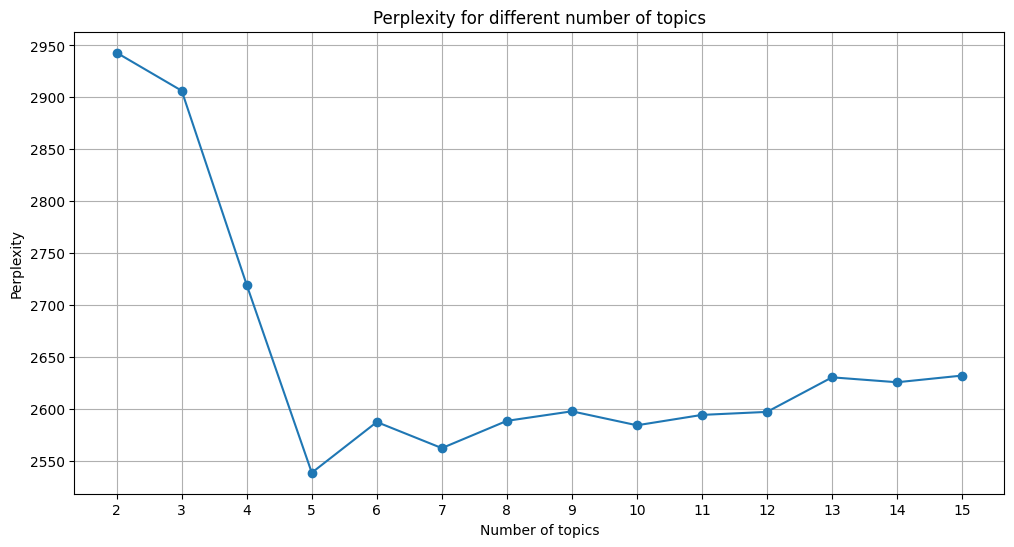

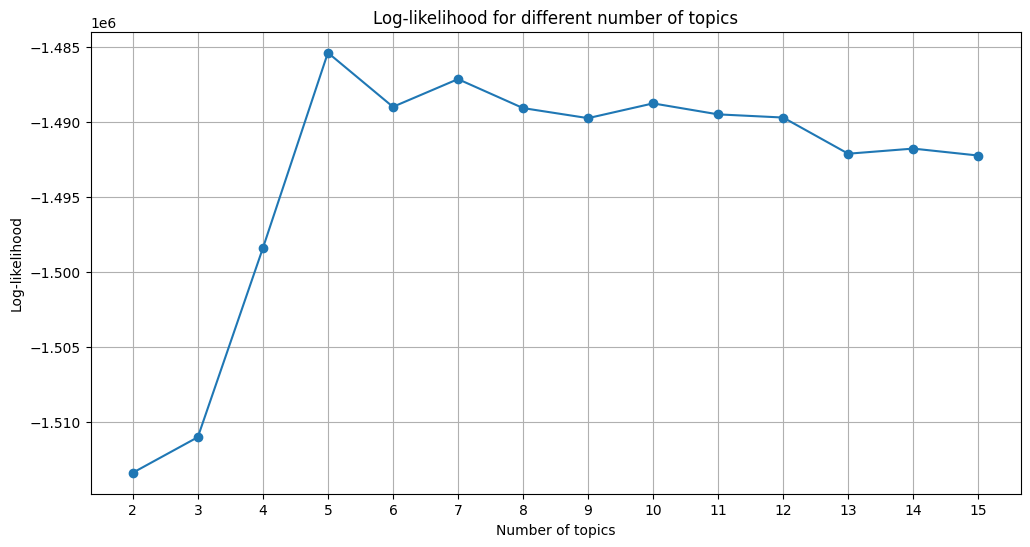

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, perplexities, marker='o')
plt.title('Perplexity for different number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(num_topics_range, log_likelihoods, marker='o')
plt.title('Log-likelihood for different number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Log-likelihood')
plt.xticks(num_topics_range)
plt.grid(True)
plt.show()

In [10]:
dominant_topic = None
topic_words = None

In [11]:
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()

for i in np.random.choice(len(raw_corpus), 4, replace=False):
    print(f"\nDocument №{i + 1}: {raw_corpus[i]}")
    doc_topic_distribution = best_lda_model.transform(document_term_matrix[i])
    dominant_topic = np.argmax(doc_topic_distribution)
    print(f"Dominant topic: {dominant_topic + 1}")

    topic_words = np.array(feature_names)[best_lda_model.components_[dominant_topic].argsort()[:-num_top_words - 1:-1]]
    print(f"Key words of topic: {', '.join(topic_words)}")


Document №896:  The Conservatives' campaign director has denied a report claiming he warned Michael Howard the party could not win the next general election.  The Times on Monday said Australian Lynton Crosby told the party leader to focus on trying to increase the Tories' Commons presence by 25 to 30 seats. But Mr Crosby said in a statement: "I have never had any such conversation... and I do not hold that view." Mr Howard later added there was not "one iota" of truth in the report. The strategist helped Australia's PM, John Howard, win four elections. Mr Howard appointed Mr Crosby as his elections chief last October. Mr Crosby's statement said: "The Conservative Party has been making an impact on the issues of lower tax and controlled immigration over the past week." It added: "The Labour Party will be wanting to do all they can to distract attention away from the issues that really matter to people." 
Dominant topic: 2
Key words of topic: mr, people, labour, government, election, p

In [12]:
def print_top_words(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic №{topic_idx + 1}:")
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(" ".join(top_words))

print("\nKey words for each topic:")
print_top_words(best_lda_model, feature_names, 10)


Key words for each topic:

Topic №1:
use people game phone technology make mobile service music new

Topic №2:
mr people labour government election party blair make minister tory

Topic №3:
film best award star include song new make actor music

Topic №4:
game play win player make time england world come match

Topic №5:
bn company market rise mr firm economy government new growth
